In [9]:
!capture --no-stderr
%pip install -U langgraph langchain-community langchain-core pytz langchain_openai langchain-groq tavily-python pandas openai

zsh:1: command not found: capture

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
# _set_env("NEBIUS_API_KEY")
# _set_env("GROQ_API_KEY")
# _set_env("TAVILY_API_KEY")
# import json
# from google.oauth2 import service_account

# with open("nth-segment-441401-d7-14b6945a2429.json") as f:
#     key_dict = json.load(f)
# credentials = service_account.Credentials.from_service_account_info(key_dict)


In [11]:
import sqlite3
import json
from datetime import date, datetime
from typing import Optional, List, Dict
# from decimal import Decimal

import pytz
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

db="data/shopping.db"

@tool
def fetch_customer_relate_information(config: RunnableConfig) -> list[dict]:
    """Fetch all information for the user along with corresponding cart information.

    Returns:
        A list of dictionaries where each dictionary contains the order details,
        associated cart details belonging to the user.
    """
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)
    if not user_id:
        raise ValueError("No user ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        u.id as user_id, u.name as user_name,u.email,
        o.id as order_id,o.total_amount,o.status as order_status,o.created_at as order_date,
        oi.product_id,oi.quantity as order_quantity,oi.price_at_time as order_price,
        ci.id as cart_item_id,ci.quantity as cart_quantity,ci.price_at_time as cart_price,
        p.name as product_name,p.description as product_description
    FROM users u
    LEFT JOIN orders o ON u.id = o.user_id
    LEFT JOIN order_items oi ON o.id = oi.order_id
    LEFT JOIN cart_items ci ON u.id = ci.user_id
    LEFT JOIN products p ON p.id = COALESCE(oi.product_id, ci.product_id)
    WHERE u.id = ?
    """
    cursor.execute(query, (user_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return {
        "user_info": results[0] if results else {},
        "orders": [r for r in results if r.get('order_id')],
        "cart_items": [r for r in results if r.get('cart_item_id')],
        "reviews": [r for r in results if r.get('rating')]
    }



@tool
def search_products(
    product_id: Optional[str] = None,
    name: Optional[str] = None,
    category_name: Optional[str] = None,
    min_price: Optional[float] = None,
    max_price: Optional[float] = None,
    min_inventory: Optional[int] = None
) -> str:  # Changed return type to str
    """
    Search products based on various criteria
    
    Args:
        product_id: Product ID to search for
        name: Product name (partial match)
        category_id: Category ID to filter by
        min_price: Minimum price threshold
        max_price: Maximum price threshold
        min_inventory: Minimum inventory level
    
    Returns:
        JSON string of matching products
    """
    try:
        conn = sqlite3.connect(db)
        cursor = conn.cursor()

        query = """
        SELECT 
            p.*,
            pc.name as category_name
        FROM products p
        LEFT JOIN product_categories pc ON p.category_id = pc.id
        WHERE 1=1
        """
        params = []
        
        if product_id:
            query += " AND id = ?"
            params.append(product_id)
            
        if name:
            # Split search terms and check both product and category
            search_words = name.lower().split()
            like_conditions = []
            
            for word in search_words:
                like_conditions.append("""
                    (
                        LOWER(p.name) LIKE ? 
                        OR LOWER(p.description) LIKE ?
                        OR LOWER(pc.name) LIKE ?  -- Include category name in main search
                    )
                """)
                params.extend([f"%{word}%", f"%{word}%", f"%{word}%"])
            
            if like_conditions:
                query += " AND (" + " AND ".join(like_conditions) + ")"
            
            
        
        if min_price is not None:
                query += " AND price >= ?"
                params.append(float(min_price))
                
        if max_price is not None:
            query += " AND price <= ?"
            params.append(float(max_price))
            
        if min_inventory:
            query += " AND inventory >= ?"
            params.append(min_inventory)
        
         # Debug prints
        print(f"Query: {query}")
        print(f"Params: {params}")

        cursor.execute(query, params)
        results = [
                dict(zip(('id', 'name', 'description', 'price', 'category_id', 'inventory'), row))
                for row in cursor.fetchall()
            ]
        
        # Convert results to JSON string
        return json.dumps(results)
        
    except Exception as e:
        return f"Error searching products: {str(e)}"
    finally:
        cursor.close()
        conn.close()

@tool
def add_product_to_cartitems(
    product_id: str,
    quantity: int = 1,
    *,
    config: RunnableConfig
) -> str:
    """
    Add a product to user's shopping cart with inventory validation
    
    Args:
        product_id: Product ID to add
        quantity: Quantity to add (default=1)
        config: Configuration containing user_id
    
    Returns:
        Success/failure message
    """
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("No user ID configured")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    try:
        # Check product exists and has sufficient inventory
        # Debug: Inventory check query
        inventory_query = "SELECT price, inventory FROM products WHERE id = ?"
        # print("\n=== Debug: Inventory Check ===")
        # print(f"Query: {inventory_query}")
        # print(f"Params: {(product_id,)}")

        cursor.execute(
            "SELECT price, inventory FROM products WHERE id = ?",
            (product_id,)
        )
        result = cursor.fetchone()
        if not result:
            return json.dumps({
                "status": "error",
                "message": f"Product {product_id} not found"
            })
        
        price,available_inventory = result
        # print(f"price: {price}")
        # print(f"available_inventory: {available_inventory}")
        # print(f"quantity: {quantity}")
        # Validate quantity
        if quantity <= 0:
            return "Quantity must be positive"
            
        if quantity > available_inventory:
            print(f"Not enough inventory")
            return f"Not enough inventory. Only {available_inventory} units available"


        # Check if product already in cart
        cursor.execute("""
            SELECT id, quantity FROM cart_items 
            WHERE user_id = ? AND product_id = ?
        """, (user_id, product_id))

        existing_cart_item = cursor.fetchone()

        if existing_cart_item:
            # Update existing cart item
            cart_item_id, current_qty = existing_cart_item
            new_qty = current_qty + quantity

            # Check total quantity
            if new_qty > available_inventory:
                return f"Cannot add {quantity} more units. Cart already has {current_qty} units and only {available_inventory} available"
                
            cursor.execute("""
                UPDATE cart_items 
                SET quantity = ?, price_at_time = ?
                WHERE id = ?
            """, (new_qty, price, cart_item_id))
        else:
            # Create new cart item
            cart_item_id = f"CART{len(str(user_id))}_{product_id}"
            cursor.execute("""
                INSERT INTO cart_items (id, user_id, product_id, quantity, price_at_time)
                VALUES (?, ?, ?, ?, ?)
            """, (cart_item_id, user_id, product_id, quantity, price))
        
        conn.commit()
        return f"Successfully added {quantity} of product {product_id} to cart"

    except Exception as e:
        return f"Error adding to cart: {str(e)}"
    finally:
        cursor.close()
        conn.close()


@tool
def remove_product_from_cartitems(
    product_id: str,
    quantity: Optional[int] = None,
    *,
    config: RunnableConfig
) -> str:
    """
    Remove a product from user's shopping cart
    
    Args:
        product_id: Product ID to remove
        quantity: Quantity to remove (None means remove all)
        config: Configuration containing user_id
    
    Returns:
        Success/failure message
    """
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("No user ID configured")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    try:
        # Check if product exists in cart
        cursor.execute("""
            SELECT id, quantity 
            FROM cart_items 
            WHERE user_id = ? AND product_id = ?
        """, (user_id, product_id))
        
        cart_item = cursor.fetchone()
        if not cart_item:
            return f"Product {product_id} not found in cart"

        cart_item_id, current_qty = cart_item

        if quantity is None or quantity >= current_qty:
            # Remove entire cart item
            cursor.execute("DELETE FROM cart_items WHERE id = ?", (cart_item_id,))
            msg = f"Removed all {current_qty} units of product {product_id} from cart"
        else:
            # Reduce quantity
            new_qty = current_qty - quantity
            cursor.execute("""
                UPDATE cart_items 
                SET quantity = ? 
                WHERE id = ?
            """, (new_qty, cart_item_id))
            msg = f"Removed {quantity} units of product {product_id} from cart"

        conn.commit()
        return msg

    except Exception as e:
        return f"Error removing from cart: {str(e)}"
    finally:
        cursor.close()
        conn.close()

@tool
def search_products_with_recommendations(
    search_term: str,
    limit: int = 5,
    *,
    config: RunnableConfig
) -> List[Dict]:
    """
    Search products by name/description similarity and include recommendations
    
    Args:
        search_term: Text to search for in product name/description
        limit: Maximum number of results to return
    Returns:
        List of products sorted by relevance score
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    try:
        # Using LIKE with wildcards for basic text matching
        # Adding relevance scoring based on match location
        query = """
        WITH matched_products AS (
            SELECT 
                p.*,
                CASE 
                    WHEN p.name LIKE ? THEN 3  -- Exact name match
                    WHEN p.name LIKE ? THEN 2  -- Name contains term
                    WHEN p.description LIKE ? THEN 1  -- Description contains term
                    ELSE 0
                END as relevance_score,
                pc.name as category_name
            FROM products p
            LEFT JOIN product_categories pc ON p.category_id = pc.id
            WHERE 
                p.name LIKE ? OR 
                p.name LIKE ? OR 
                p.description LIKE ?
        )
        SELECT 
            id, name, description, price, 
            category_id, inventory, 
            category_name, relevance_score
        FROM matched_products
        ORDER BY relevance_score DESC, name ASC
        LIMIT ?
        """
        
        search_patterns = [
            f"{search_term}",         # Exact match
            f"%{search_term}%",       # Contains term
            f"%{search_term}%"        # Description contains
        ]
        
        cursor.execute(query, 
                      search_patterns + 
                      search_patterns + 
                      [limit])

        columns = [
            'id', 'name', 'description', 'price',
            'category_id', 'inventory', 'category_name',
            'relevance_score'
        ]
        
        return [dict(zip(columns, row)) for row in cursor.fetchall()]

    except Exception as e:
        return f"Error searching products: {str(e)}"
    finally:
        cursor.close()
        conn.close()
     

In [12]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [13]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


llm = ChatOpenAI(
            api_key=os.environ.get("OPENAI_API_KEY"), 
            base_url="https://chatapi.littlewheat.com/v1/",
            model="gpt-3.5-turbo-0125",
        )

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful customer support assistant. 
             Use the provided tools to search for products to assist the user's queries. 
            When showing search results:
            1. ALWAYS start with "I found X items matching your search:"
            2. List EVERY product in numbered format
            3. Use consistent formatting for each product:
            ```
            N. [Product Name]
                - Description: [Description]
                - Price: $[Price]
                - Stock: [Inventory] units available
            ```
            4. After listing all items, add a comparison section:
            - Price comparison
            - Feature comparison
            - Best value recommendation
            
            Example format:
            "I found 3 items matching your search:
            
            1. [First Product]
            - Description: [Details]
            - Price: $XXX
            - Stock: XXX units
            
            2. [Second Product]
            ..."
             Shopping cart management is also available. You can also add and remove products from the shopping cart. 
             Order tracking and history are also available. Product information and availability can be checked. 
             You can also provide recommendations based on the user's preferences and the products we have. 
            \n\nCurrent user:\n<User>\n{user_info}\n</User>
            \nCurrent time: {time}.""",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)



# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    # TavilySearchResults(max_results=1),
    fetch_customer_relate_information,
    search_products,
    search_products_with_recommendations
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    add_product_to_cartitems,
    remove_product_from_cartitems,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)


In [14]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

def user_info(state: State):
    return {"user_info": fetch_customer_relate_information.invoke({})}

# Define nodes: these do the work
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")


builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node("sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools))
builder.add_edge("fetch_user_info", "assistant")

def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


# Define edges: these determine how the control flow moves
builder.add_conditional_edges(
    "assistant",route_tools,["safe_tools", "sensitive_tools",END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
    )

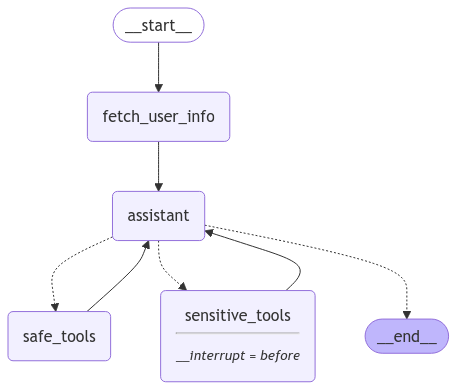

In [15]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Show me Premium wireless tires under $400",
    "What are your best-selling computers?", 
    "Find products similar to the Sony WH-1000XM4",
    "Show me products in the Electronics category",
    "What's the price difference between Apple AirPods Pro and Bose QuietComfort 35?",
    "Add 200 pairs of AirPods Pro to my cart",
    "What's in my shopping cart?",
    "Remove all AirPods Pro from my cart", 
    "What's in my shopping cart?",
    "Show my recent orders",
    "What's the status of order ORD003?",
    "When will my headphones be delivered?",
    "Can I modify my recent order?",
    "Show me my order history",
    "Is this item available in other colors?",
    "How many MacBook do you have in stock?",
    "What are the shipping options for this item?",
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # This is the user ID we are fetching information for
        "user_id": "USER001",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

Show me Premium wireless tires under $400
================================== Ai Message ==================================
Tool Calls:
  search_products (call_iAmQTkfSuY1ZAIVJ6scMdcZi)
 Call ID: call_iAmQTkfSuY1ZAIVJ6scMdcZi
  Args:
    max_price: 400
    name: wireless
Query: 
        SELECT 
            p.*,
            pc.name as category_name
        FROM products p
        LEFT JOIN product_categories pc ON p.category_id = pc.id
        WHERE 1=1
         AND (
                    (
                        LOWER(p.name) LIKE ? 
                        OR LOWER(p.description) LIKE ?
                        OR LOWER(pc.name) LIKE ?  -- Include category name in main search
                    )
                ) AND price <= ?
Params: ['%wireless%', '%wireless%', '%wireless%', 400.0]
================================= Tool Message =================================
Name: search_products

[{"id": "PROD001"